In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_MCAR = pd.read_csv('hyperparameter_tables/hyperparameter_results_MCAR.csv', index_col=0)
df_MNAR = pd.read_csv('hyperparameter_tables/hyperparameter_results_MNAR.csv', index_col=0)
df_MAR = pd.read_csv('hyperparameter_tables/hyperparameter_results_MAR.csv', index_col=0)

In [3]:
def runtime_assoc(df):
    # --- Define target and features ---
    y = df["runtime_seconds"]
    
    drop_cols = ["RMSE", "MAE", "R2", "Pearson_r", "runtime_seconds"]
    X = df.drop(columns=drop_cols).copy()
    
    # Encode categorical variables
    for col in X.select_dtypes(include=["object"]).columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    
    # --- Impute missing values ---
    imp_numeric = SimpleImputer(strategy="median")
    imp_categorical = SimpleImputer(strategy="most_frequent")
    
    X_imputed = X.copy()
    for col in X_imputed.columns:
        if np.issubdtype(X_imputed[col].dtype, np.number):
            X_imputed[col] = imp_numeric.fit_transform(X_imputed[[col]])
        else:
            X_imputed[col] = imp_categorical.fit_transform(X_imputed[[col]])
    
    # --- Fit RandomForest ---
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_imputed, y)
    # --- Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_imputed.columns).sort_values(ascending=False)
    return importances

In [4]:
def rmse_assoc(df):
    # --- Define target and features ---
    y = df["RMSE"]
    
    drop_cols = ["RMSE", "MAE", "R2", "Pearson_r", "runtime_seconds"]
    X = df.drop(columns=drop_cols).copy()
    
    # Encode categorical variables
    for col in X.select_dtypes(include=["object"]).columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    
    # --- Impute missing values ---
    imp_numeric = SimpleImputer(strategy="median")
    imp_categorical = SimpleImputer(strategy="most_frequent")
    
    X_imputed = X.copy()
    for col in X_imputed.columns:
        if np.issubdtype(X_imputed[col].dtype, np.number):
            X_imputed[col] = imp_numeric.fit_transform(X_imputed[[col]])
        else:
            X_imputed[col] = imp_categorical.fit_transform(X_imputed[[col]])
    
    # --- Fit RandomForest ---
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_imputed, y)
    # --- Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_imputed.columns).sort_values(ascending=False)
    return importances

In [5]:
def assoc_clustering(df, groupby_col, target_col='runtime_seconds'):
    
    # Load your data (already loaded as df)
    #target_col = ""
    
    # For each prioritization mode, cluster runtimes into 2 groups (low/high peak)
    results = []
    for mode, df_sub in df.groupby(groupby_col):
        runtimes = df_sub[[target_col]].values
    
        # cluster runtimes into 2 groups
        kmeans = KMeans(n_clusters=2, random_state=42).fit(runtimes)
        df_sub[f"{target_col}_cluster"] = kmeans.labels_
    
        # summarize hyperparameter values per cluster
        summary = df_sub.groupby(f"{target_col}_cluster").agg({
            target_col: ["mean", "std", "count"],
            "partner_proportion": "mean",
            "edge_threshold_rule": lambda x: x.mode()[0] if not x.mode().empty else None,
            "method": lambda x: x.mode()[0] if not x.mode().empty else None,
            "model_func": lambda x: x.mode()[0] if not x.mode().empty else None,
            "max_rounds": "median"
        })
        summary[groupby_col] = mode
        results.append(summary)
    
    summary_df = pd.concat(results)
    
    return summary_df

## AGAINST RUNTIME

,MCAR,MNAR,MAR
prioritization_mode,0.993759,0.976773,0.988743
partner_proportion,0.005826,0.011550,0.008927
edge_threshold_rule,0.000252,0.001801,0.000309
method,0.000078,0.006686,0.001230
edge_threshold_value,0.000062,0.001182,0.000506
alpha,0.000011,0.000980,0.000154
beta,0.000011,0.001029,0.000131
model_func,0.000000,0.000000,0.000000
max_rounds,0.000000,0.000000,0.000000


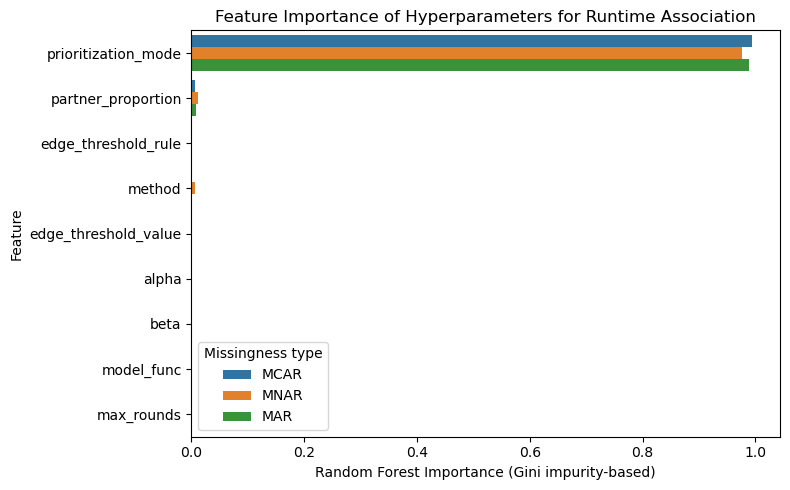

In [7]:
mcar_assoc = runtime_assoc(df_MCAR)
mnar_assoc = runtime_assoc(df_MNAR)
mar_assoc  = runtime_assoc(df_MAR)

runtime_assoc_df = pd.merge(pd.merge(pd.DataFrame(mcar_assoc, columns=['MCAR']), pd.DataFrame(mnar_assoc, columns=['MNAR']), left_index=True, right_index=True),
                             pd.DataFrame(mar_assoc, columns=['MAR']), left_index=True, right_index=True)

display(runtime_assoc_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
runtime_assoc_df.reset_index(inplace=True)  # move feature names into a column
runtime_assoc_df.rename(columns={"index": "feature"}, inplace=True)

runtime_assoc_long = runtime_assoc_df.melt(id_vars="feature", var_name="missingness", value_name="importance")

sns.barplot(
    data=runtime_assoc_long,
    x="importance", y="feature", hue="missingness"
)

plt.title("Feature Importance of Hyperparameters for Runtime Association")
plt.xlabel("Random Forest Importance (Gini impurity-based)")
plt.ylabel("Feature")
plt.legend(title="Missingness type")
plt.tight_layout()
#plt.savefig('results_figures/comparison/feature_importance_runtime.svg')
#plt.savefig('results_figures/comparison/feature_importance_runtime.png')
plt.show()

In [8]:
display(assoc_clustering(df_MCAR, 'prioritization_mode'))
display(assoc_clustering(df_MNAR, 'prioritization_mode'))
display(assoc_clustering(df_MAR, 'prioritization_mode'))

runtime_seconds                 partner_proportion   
                                   mean       std count               mean   
runtime_seconds_cluster                                                      
0                              2.419144  0.321121    32              0.115  \
1                              5.606162  0.729005    16              0.250   
0                             45.304772  0.285550    32              0.115   
1                             49.086981  0.626771    16              0.250   

                        edge_threshold_rule       method        model_func   
                                   <lambda>     <lambda>          <lambda>   
runtime_seconds_cluster                                                      
0                                       p85  betweenness  LinearRegression  \
1                                       p85  betweenness  LinearRegression   
0                                       p85  betweenness  LinearRegression   
1                                       p85  betweenness  LinearRegression   

                        max_rounds prioritization_mode  
                            median                      
runtime_seconds_cluster                                 
0                              1.0          centrality  
1                              1.0          centrality  
0                              1.0             utility  
1                              1.0             utility

runtime_seconds                 partner_proportion   
                                   mean       std count               mean   
runtime_seconds_cluster                                                      
0                              0.594983  0.040083    36             0.1150  \
1                              1.320972  0.053079    18             0.2500   
0                             11.152586  0.477863    50             0.1528   
1                             14.769925  1.166533     4             0.2500   

                        edge_threshold_rule       method        model_func   
                                   <lambda>     <lambda>          <lambda>   
runtime_seconds_cluster                                                      
0                                       p85  betweenness  LinearRegression  \
1                                       p85  betweenness  LinearRegression   
0                                       p85       degree  LinearRegression   
1                                       p85  betweenness  LinearRegression   

                        max_rounds prioritization_mode  
                            median                      
runtime_seconds_cluster                                 
0                              1.0          centrality  
1                              1.0          centrality  
0                              1.0             utility  
1                              1.0             utility

runtime_seconds                 partner_proportion   
                                   mean       std count               mean   
runtime_seconds_cluster                                                      
0                              2.748464  0.073923    36           0.115000  \
1                              7.397883  0.236498    18           0.250000   
0                             57.962150  2.458627    18           0.244444   
1                             52.502975  1.408541    36           0.117778   

                        edge_threshold_rule       method        model_func   
                                   <lambda>     <lambda>          <lambda>   
runtime_seconds_cluster                                                      
0                                       p85  betweenness  LinearRegression  \
1                                       p85  betweenness  LinearRegression   
0                                       p85  betweenness  LinearRegression   
1                                       p85  eigenvector  LinearRegression   

                        max_rounds prioritization_mode  
                            median                      
runtime_seconds_cluster                                 
0                              1.0          centrality  
1                              1.0          centrality  
0                              1.0             utility  
1                              1.0             utility

In [9]:
print(f"Centrality: {(df_MCAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['centrality'][0]+df_MNAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['centrality'][0]+df_MAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['centrality'][0])/3}")
print(f"Utility: {(df_MCAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['utility'][0]+df_MNAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['utility'][0]+df_MAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['utility'][0])/3}")



Centrality: 2.872244444444444
Utility: 37.43624845679012


In [10]:
print(df_MCAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['utility'][0])
print(df_MNAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['utility'][0])
print(df_MAR.groupby('prioritization_mode')[['runtime_seconds']].mean().loc['utility'][0])


46.565508333333334
11.420537037037038
54.3227


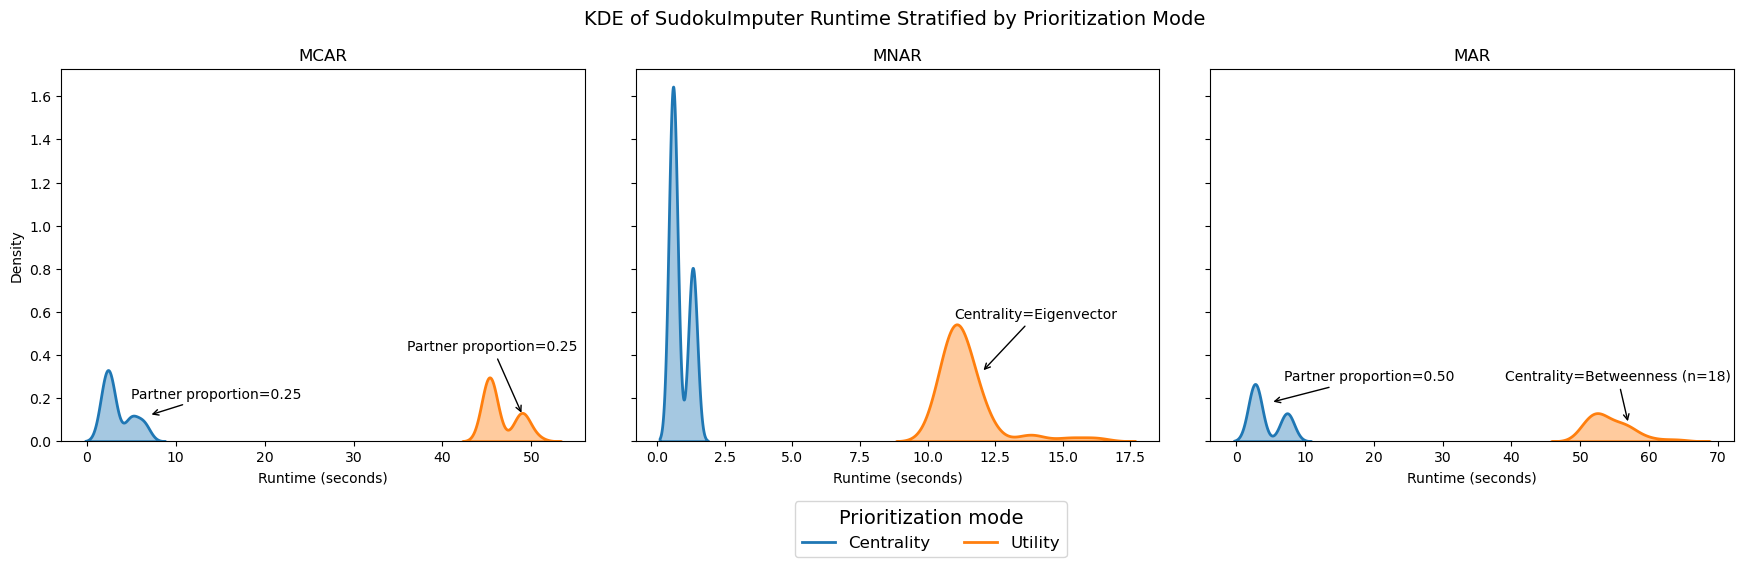

In [11]:
### import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

datasets = {
    "MCAR": df_MCAR,
    "MNAR": df_MNAR,
    "MAR": df_MAR
}

annotations = {
    "MCAR": [
        dict(text="Partner proportion=0.25", xy=(7, 0.12), xytext=(5, 0.2)),
        dict(text="Partner proportion=0.25", xy=(49, 0.12), xytext=(36, 0.42)),
    ],
    "MNAR": [
        dict(text="Centrality=Eigenvector", xy=(12, 0.32), xytext=(11, 0.57))
    ],
    "MAR": [
        dict(text="Partner proportion=0.50", xy=(5, 0.18), xytext=(7, 0.28)),
        dict(text="Centrality=Betweenness (n=18)", xy=(57, 0.08), xytext=(39, 0.28))
    ]
}

# 1) Determine global hue order (so colors are consistent across subplots)
all_df = pd.concat(datasets.values(), axis=0, ignore_index=True)
hue_var = "prioritization_mode"
hue_order = sorted(all_df[hue_var].dropna().unique())

# 2) Lock a palette so the proxies match the kde colors
palette = sns.color_palette(n_colors=len(hue_order))

# Map label -> color for proxies
label_to_color = {label: palette[i] for i, label in enumerate(hue_order)}

for ax, (title, df) in zip(axes, datasets.items()):
    sns.kdeplot(
        data=df,
        x="runtime_seconds",
        hue=hue_var,
        hue_order=hue_order,
        palette=palette,
        common_norm=False,
        fill=True,
        alpha=0.4,
        linewidth=2,
        ax=ax,
        legend=False,           # 3) Don't create per-axes legends
    )
    ax.set_title(f"{title}")
    ax.set_xlabel("Runtime (seconds)")
    ax.set_ylabel("Density")

    # Add annotations
    for ann in annotations.get(title, []):
        ax.annotate(
            ann["text"],
            xy=ann["xy"],
            xytext=ann["xytext"],
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            fontsize=10,
            color="black"
        )

# 4) Build a single figure-level legend using proxy handles
from matplotlib.lines import Line2D
proxies = [Line2D([0], [0], lw=2, color=label_to_color[l]) for l in hue_order]
labels = [str(l).capitalize() for l in hue_order]

fig.legend(
    proxies, labels,
    title="Prioritization mode",
    bbox_to_anchor=(0.6, 0.013),
    ncol=len(labels),
    frameon=True,
    fontsize=12,
    title_fontsize=14
)

fig.suptitle("KDE of SudokuImputer Runtime Stratified by Prioritization Mode", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 1])
#plt.savefig('results_figures/comparison/runtime_hyperparam.png')
#plt.savefig('results_figures/comparison/runtime_hyperparam.svg')
plt.show()


## AGAINST RMSE

,MCAR,MNAR,MAR
partner_proportion,0.888412,0.896517,0.442965
prioritization_mode,0.047234,0.022154,0.137490
edge_threshold_rule,0.028436,0.012959,0.161535
method,0.022964,0.020398,0.192220
beta,0.006165,0.020421,0.012024
alpha,0.005737,0.017245,0.011481
edge_threshold_value,0.001051,0.010306,0.042285
model_func,0.000000,0.000000,0.000000
max_rounds,0.000000,0.000000,0.000000


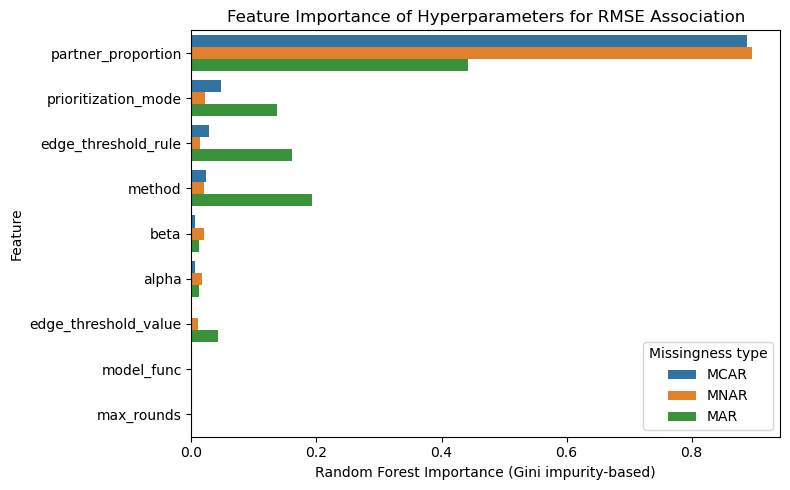

In [13]:
mcar_assoc_rmse = rmse_assoc(df_MCAR)
mnar_assoc_rmse = rmse_assoc(df_MNAR)
mar_assoc_rmse  = rmse_assoc(df_MAR)

rmse_assoc_df = pd.merge(pd.merge(pd.DataFrame(mcar_assoc_rmse, columns=['MCAR']), pd.DataFrame(mnar_assoc_rmse, columns=['MNAR']), left_index=True, right_index=True),
                             pd.DataFrame(mar_assoc_rmse, columns=['MAR']), left_index=True, right_index=True)

display(rmse_assoc_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
rmse_assoc_df.reset_index(inplace=True)  # move feature names into a column
rmse_assoc_df.rename(columns={"index": "feature"}, inplace=True)

rmse_assoc_long = rmse_assoc_df.melt(id_vars="feature", var_name="missingness", value_name="importance")

sns.barplot(
    data=rmse_assoc_long,
    x="importance", y="feature", hue="missingness"
)

plt.title("Feature Importance of Hyperparameters for RMSE Association")
plt.xlabel("Random Forest Importance (Gini impurity-based)")
plt.ylabel("Feature")
plt.legend(title="Missingness type")
plt.tight_layout()
#plt.savefig('results_figures/comparison/feature_importance_rmse.svg')
#plt.savefig('results_figures/comparison/feature_importance_rmse.png')
plt.show()

In [14]:
display(assoc_clustering(df_MCAR, 'prioritization_mode', target_col='RMSE'))
display(assoc_clustering(df_MNAR, 'prioritization_mode', target_col='RMSE'))
display(assoc_clustering(df_MAR, 'prioritization_mode', target_col='RMSE'))

RMSE               partner_proportion edge_threshold_rule   
                  mean     std count               mean            <lambda>   
RMSE_cluster                                                                  
0             0.003839  0.0000    32              0.115                 p85  \
1             0.065740  0.0169    16              0.250                 p85   
0             0.003839  0.0000    32              0.115                 p85   
1             0.046181  0.0000    16              0.250                 p85   

                   method        model_func max_rounds prioritization_mode  
                 <lambda>          <lambda>     median                      
RMSE_cluster                                                                
0             betweenness  LinearRegression        1.0          centrality  
1             betweenness  LinearRegression        1.0          centrality  
0             betweenness  LinearRegression        1.0             utility  
1             betweenness  LinearRegression        1.0             utility

RMSE                 partner_proportion edge_threshold_rule   
                  mean       std count               mean            <lambda>   
RMSE_cluster                                                                    
0             0.677520  0.006826    40             0.1285                 p85  \
1             0.732362  0.014888    14             0.2500                 p85   
0             0.675283  0.000000    36             0.1150                 p85   
1             0.723647  0.003063    18             0.2500                 p85   

                   method        model_func max_rounds prioritization_mode  
                 <lambda>          <lambda>     median                      
RMSE_cluster                                                                
0             eigenvector  LinearRegression        1.0          centrality  
1             betweenness  LinearRegression        1.0          centrality  
0             betweenness  LinearRegression        1.0             utility  
1             betweenness  LinearRegression        1.0             utility

RMSE                 partner_proportion edge_threshold_rule   
                  mean       std count               mean            <lambda>   
RMSE_cluster                                                                    
0             0.009711  0.004208    49           0.150816                 p85  \
1             0.046855  0.008996     5           0.250000                 p85   
0             0.007288  0.000000    36           0.115000                 p85   
1             0.014030  0.000019    18           0.250000                 p85   

                   method        model_func max_rounds prioritization_mode  
                 <lambda>          <lambda>     median                      
RMSE_cluster                                                                
0                  degree  LinearRegression        1.0          centrality  
1             eigenvector  LinearRegression        1.0          centrality  
0             betweenness  LinearRegression        1.0             utility  
1             betweenness  LinearRegression        1.0             utility

/var/folders/7v/1hw0skqj72dczc6xdjymzmyh0000gn/T/ipykernel_71308/743677978.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", max(10, len(groups_sorted)))
/var/folders/7v/1hw0skqj72dczc6xdjymzmyh0000gn/T/ipykernel_71308/743677978.py:183: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0])


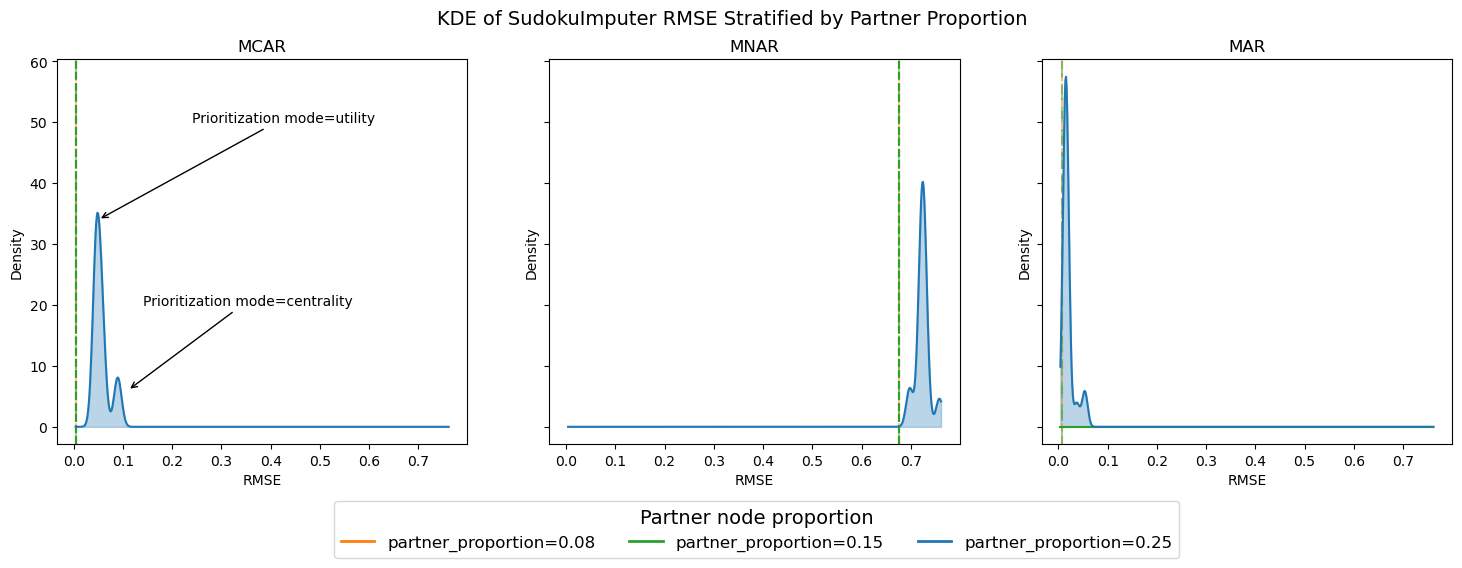

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from numpy.linalg import LinAlgError
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# =========================
# CONFIG
# =========================
COL_GROUP = "partner_proportion"
COL_VALUE = "RMSE"
EPS = 1e-12  # tolerance to treat variance/range as zero

datasets = {
    "MCAR": df_MCAR,
    "MNAR": df_MNAR,
    "MAR":  df_MAR,
}


annotations = {
    "MCAR": [
        dict(text="Prioritization mode=centrality", xy=(0.11, 6), xytext=(0.14, 20)),
        dict(text="Prioritization mode=utility", xy=(0.05, 34), xytext=(0.24, 50)),
    ]#,
    #"MNAR": [
    #    dict(text="Centrality=Eigenvector", xy=(12, 0.32), xytext=(11, 0.57))
    #],
    #"MAR": [
    #    dict(text="Partner proportion=0.50", xy=(5, 0.18), xytext=(7, 0.28)),
    #    dict(text="Centrality=Betweenness (n=18)", xy=(57, 0.08), xytext=(39, 0.28))
    #]
}

# =========================
# UTILITIES
# =========================
def clean_vals(df, value_col):
    vals = pd.to_numeric(df[value_col], errors="coerce")
    return df.assign(**{value_col: vals}).replace([np.inf, -np.inf], np.nan)

def build_group_colors(datasets, group_col, force_blue_value=0.25):
    # get union of groups across all datasets
    groups_union = set()
    for d in datasets.values():
        if group_col in d.columns:
            groups_union |= set(pd.Series(d[group_col]).dropna().unique())
    groups_sorted = sorted(groups_union)

    # start from tab10
    cmap = cm.get_cmap("tab10", max(10, len(groups_sorted)))
    default_blue = "#1f77b4"

    group_colors = {}
    cycle_idx = 0
    for g in groups_sorted:
        if g == force_blue_value:
            group_colors[g] = default_blue
            continue

        # assign next non-blue color from cmap
        color = cmap(cycle_idx % cmap.N)
        # avoid duplicating the default blue
        while mcolors.to_hex(color) == default_blue:
            cycle_idx += 1
            color = cmap(cycle_idx % cmap.N)

        group_colors[g] = color
        cycle_idx += 1

    return group_colors, groups_sorted

def compute_global_x(datasets, value_col, n=600):
    all_vals = []
    for d in datasets.values():
        if value_col in d.columns:
            all_vals.append(pd.to_numeric(d[value_col], errors="coerce"))
    all_vals = pd.concat(all_vals).replace([np.inf, -np.inf], np.nan).dropna()
    xmin, xmax = all_vals.min(), all_vals.max()
    # in case xmin == xmax, give a tiny padding
    if not np.isfinite(xmin) or not np.isfinite(xmax):
        xmin, xmax = 0.0, 1.0
    if np.isclose(xmin, xmax):
        pad = 1e-6 if xmax == 0 else 1e-3 * abs(xmax)
        xmin, xmax = xmin - pad, xmax + pad
    x = np.linspace(xmin, xmax, n)
    return x

def plot_kde_by_group(ax, df, title, x, group_colors):
    df_clean = clean_vals(df, COL_VALUE)

    # per-axis legend entries (only for groups that appear in this dataset)
    legend_entries = []

    if df_clean[COL_VALUE].dropna().empty:
        ax.set_title(f"{title} (no data)")
        return legend_entries

    groups = df_clean[COL_GROUP].dropna().unique()

    for g in groups:
        s = df_clean.loc[df_clean[COL_GROUP] == g, COL_VALUE].dropna().values
        color = group_colors.get(g, "#999999")  # fallback gray if unseen

        if s.size < 2:
            if s.size == 1:
                ax.axvline(s[0], linestyle="--", color=color,
                           label=f"{COL_GROUP}={g} (const)")
                legend_entries.append((f"{COL_GROUP}={g}", color))
            continue

        unique_ct = np.unique(s).size
        rng = s.max() - s.min()
        var = np.var(s, ddof=1)

        if unique_ct < 2 or rng <= EPS or var <= EPS:
            if g == 0.15:  # special dash pattern for this group
                ax.axvline(np.mean(s), color=color, linestyle="-.", alpha=0.5,
                           dashes=(8, 3),  # longer dashes
                           label=f"{COL_GROUP}={g} (const)")
            else:
                ax.axvline(np.mean(s), color=color, linestyle="-", alpha=0.5,
                           dashes=(4, 2),  # default dashes
                           label=f"{COL_GROUP}={g} (const)")

        try:
            kde = gaussian_kde(s)
            y = kde(x)
            ax.plot(x, y, color=color, label=f"{COL_GROUP}={g}")
            ax.fill_between(x, y, alpha=0.3, color=color)
            legend_entries.append((f"{COL_GROUP}={g}", color))
        except LinAlgError:
            ax.axvline(np.mean(s), linestyle="--", color=color,
                       label=f"{COL_GROUP}={g} (const)")
            legend_entries.append((f"{COL_GROUP}={g}", color))

        # Add annotations
    for ann in annotations.get(title, []):
        ax.annotate(
            ann["text"],
            xy=ann["xy"],
            xytext=ann["xytext"],
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            fontsize=10,
            color="black"
        )
    
    ax.set_xlabel("RMSE")
    ax.set_ylabel("Density")
    ax.set_title(title)
    return legend_entries

# =========================
# PLOTTING
# =========================
group_colors, groups_sorted = build_group_colors(datasets, COL_GROUP, force_blue_value=0.25)
x = compute_global_x(datasets, COL_VALUE, n=600)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

all_legend_pairs = []
for ax, (name, df_) in zip(axes, datasets.items()):
    all_legend_pairs += plot_kde_by_group(ax, df_, name, x, group_colors)

# Build a single shared legend (unique labels in sorted group order)
# Only include groups that actually appeared in any panel
labels_seen = set()
handles = []
for g in groups_sorted:
    label = f"{COL_GROUP}={g}"
    # include only if seen
    if any(lbl == label for (lbl, _) in all_legend_pairs):
        color = group_colors[g]
        handles.append(Line2D([0], [0], color=color, lw=2, label=label))
        labels_seen.add(label)

fig.legend(title="Partner node proportion", handles=handles, bbox_to_anchor=(0.753, 0.013), ncol=min(len(handles), 5), frameon=True,
          title_fontsize=14, fontsize=12)
fig.suptitle("KDE of SudokuImputer RMSE Stratified by Partner Proportion", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0])
#plt.savefig('results_figures/comparison/rmse_hyperparam.png')
#plt.savefig('results_figures/comparison/rmse_hyperparam.svg')
plt.show()


In [16]:
for hp in ['prioritization_mode', 'method', 'edge_threshold_rule', 'edge_threshold_value', 'alpha', 'beta']:  
    display(df_MNAR[df_MNAR['partner_proportion'] == 0.25].groupby(hp)[['RMSE']].mean())

,RMSE
prioritization_mode,
centrality,0.724651
utility,0.723647


,RMSE
method,
betweenness,0.723217
degree,0.722716
eigenvector,0.726513


,RMSE
edge_threshold_rule,
p85,0.722474


,RMSE
edge_threshold_value,
0.534658,0.708079
0.647058,0.731606
0.765773,0.727738


,RMSE
alpha,
0.5,0.729940
1.0,0.730180
1.5,0.712326


,RMSE
beta,
0.5,0.712326
1.0,0.730180
1.5,0.729940


/Users/vivekkanpa/Applications/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vivekkanpa/Applications/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/vivekkanpa/Applications/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vivekkanpa/Applications/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/vivekkanpa/Applications/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensu

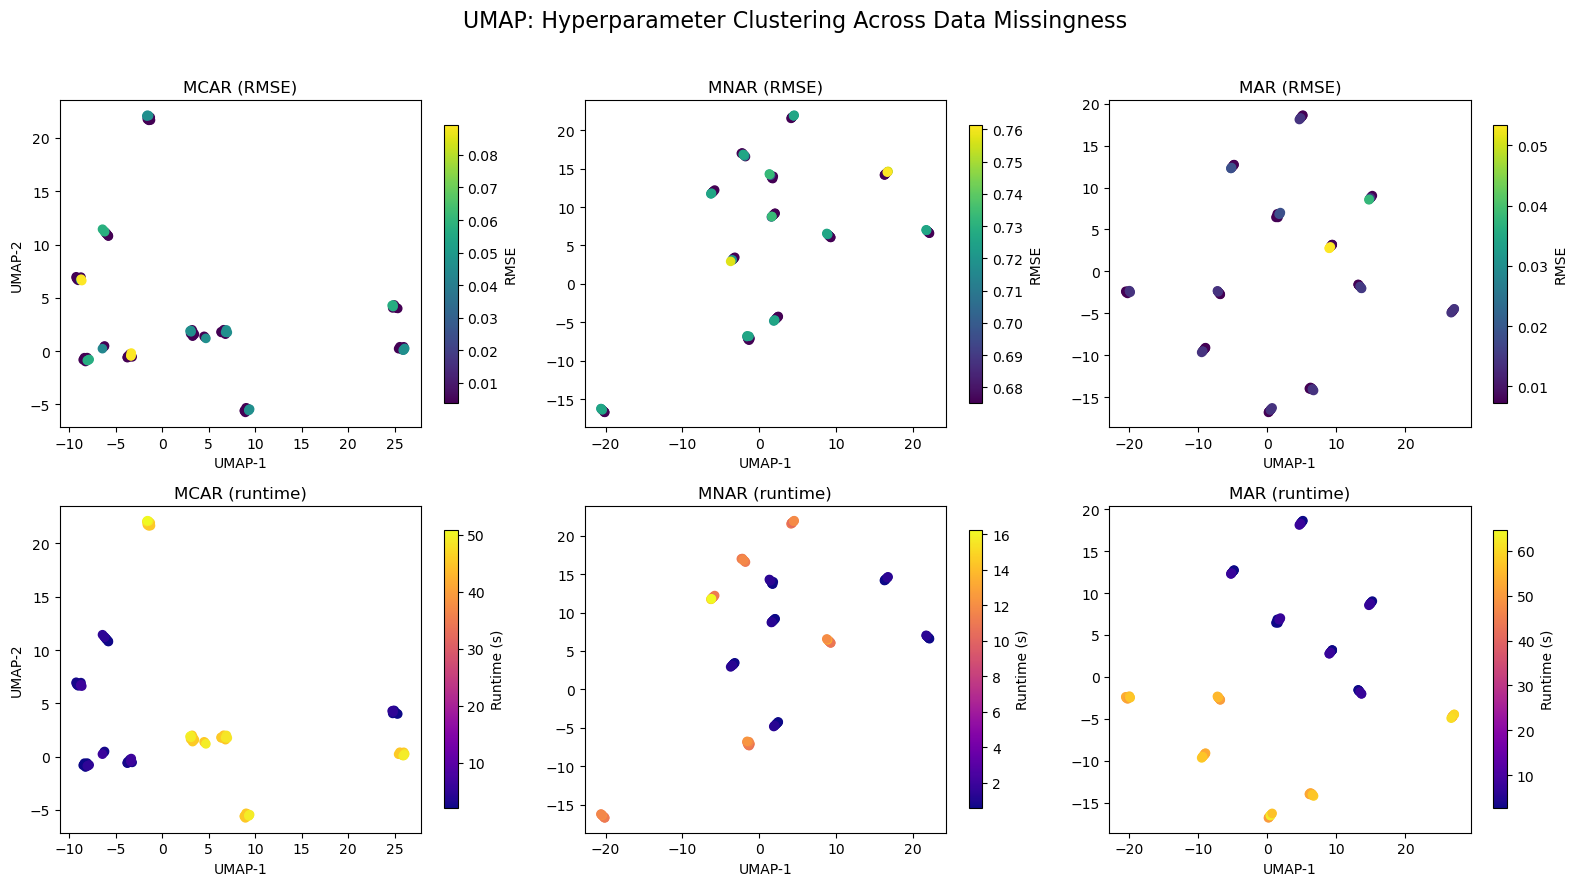

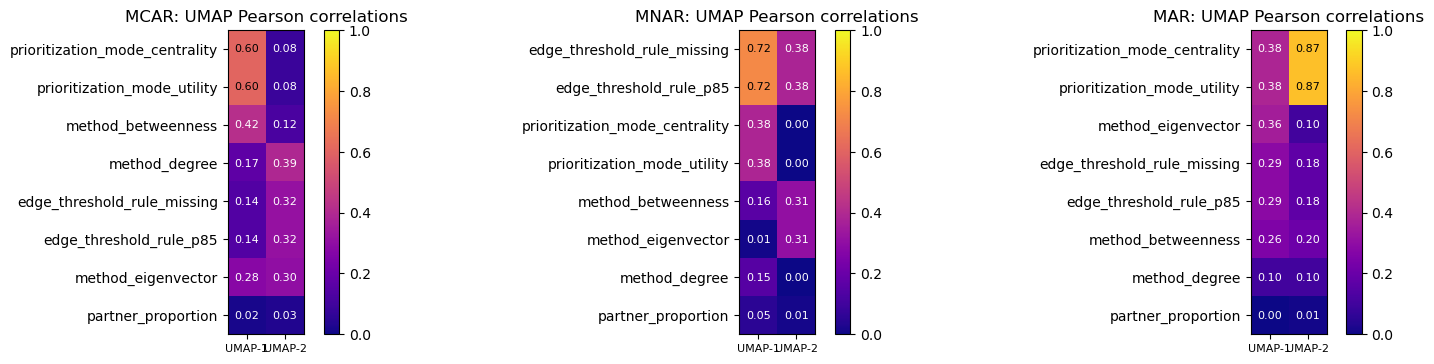

In [43]:
# UMAP Superplot + Feature↔UMAP Correlations
# Requirements: pip install umap-learn scikit-learn matplotlib pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Import UMAP
try:
    import umap
    UMAP = umap.UMAP
except Exception:
    import umap.umap_ as umap
    UMAP = umap.UMAP

# ---------- CONFIG ----------
CATEGORICAL_HP = ["method", "prioritization_mode", "edge_threshold_rule"]
NUMERIC_HP     = ["partner_proportion", "edge_threshold"]  # add/remove as needed

RANDOM_STATE   = 42
N_NEIGHBORS    = 15
MIN_DIST       = 0.1

# Your dataframes must already exist: df_MCAR, df_MNAR, df_MAR
datasets = {
    "MCAR": df_MCAR,
    "MNAR": df_MNAR,
    "MAR":  df_MAR,
}

# ---------- HELPERS ----------
def make_feature_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """Build the feature matrix X for UMAP."""
    cat_cols = [c for c in CATEGORICAL_HP if c in df.columns]
    num_cols = [c for c in NUMERIC_HP if c in df.columns]

    # One-hot encode categoricals
    try:
        enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:  # sklearn<1.4
        enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

    if cat_cols:
        X_cat = enc.fit_transform(df[cat_cols].fillna("missing"))
        X_cat = pd.DataFrame(
            X_cat, columns=enc.get_feature_names_out(cat_cols), index=df.index
        )
    else:
        X_cat = pd.DataFrame(index=df.index)

    # Numeric
    X_num = df[num_cols].copy() if num_cols else pd.DataFrame(index=df.index)
    if not X_num.empty:
        X_num = X_num.fillna(X_num.median(numeric_only=True))

    X = pd.concat([X_num, X_cat], axis=1)
    return X

def corr_df_with_umap_axes(X: pd.DataFrame, embedding: np.ndarray, method: str = "spearman") -> pd.DataFrame:
    """
    Return a DataFrame of correlations between each feature in X and UMAP axes.
    method: 'pearson' or 'spearman'
    """
    # Choose correlation function
    if method == "pearson":
        def corr(a, b): return abs(np.corrcoef(a, b)[0, 1])
    else:  # spearman
        from scipy.stats import spearmanr
        def corr(a, b): return abs(spearmanr(a, b, nan_policy="omit").correlation)

    umap1 = embedding[:, 0]
    umap2 = embedding[:, 1]

    rows = []
    for col in X.columns:
        v = X[col].values
        c1 = corr(v, umap1)
        c2 = corr(v, umap2)
        rows.append((col, c1, c2, max(abs(c1), abs(c2))))
    out = pd.DataFrame(rows, columns=["feature", "corr_UMAP1", "corr_UMAP2", "abs_max"]).set_index("feature")
    out = out.sort_values("abs_max", ascending=False)
    return out

# ---------- SUPERPLOT (2×3: RMSE top / Runtime bottom) ----------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9), constrained_layout=False)

corr_tables = {}  # store correlation DFs per dataset

for col_idx, (name, df) in enumerate(datasets.items()):
    if df is None or len(df) == 0:
        axes[0, col_idx].set_visible(False)
        axes[1, col_idx].set_visible(False)
        continue

    X = make_feature_matrix(df)
    reducer = UMAP(n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST, random_state=RANDOM_STATE)
    embedding = reducer.fit_transform(X)

    # Save correlations for later visualization/CSV
    corr_tables[name] = corr_df_with_umap_axes(X, embedding, method="spearman")
    #print(f"\nTop drivers for {name} (|corr| with UMAP axes):")
    #print(corr_tables[name].head(8))

    # --- RMSE subplot ---
    ax_rmse = axes[0, col_idx]
    sc1 = ax_rmse.scatter(embedding[:, 0], embedding[:, 1],
                          c=df["RMSE"].values, s=35, cmap="viridis")
    ax_rmse.set_title(f"{name} (RMSE)")
    ax_rmse.set_xlabel("UMAP-1")
    ax_rmse.set_ylabel("UMAP-2" if col_idx == 0 else "")
    cb1 = fig.colorbar(sc1, ax=ax_rmse, shrink=0.85)
    cb1.set_label("RMSE")

    # --- Runtime subplot ---
    ax_rt = axes[1, col_idx]
    sc2 = ax_rt.scatter(embedding[:, 0], embedding[:, 1],
                        c=df["runtime_seconds"].values, s=35, cmap="plasma")
    ax_rt.set_title(f"{name} (runtime)")
    ax_rt.set_xlabel("UMAP-1")
    ax_rt.set_ylabel("UMAP-2" if col_idx == 0 else "")
    cb2 = fig.colorbar(sc2, ax=ax_rt, shrink=0.85)
    cb2.set_label("Runtime (s)")

fig.suptitle("UMAP: Hyperparameter Clustering Across Data Missingness", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('results_figures/comparison/hyperparam_UMAP.png')
plt.savefig('results_figures/comparison/hyperparam_UMAP.svg')
plt.show()

# ---------- SECOND FIGURE: correlation heatmaps (1×3) ----------
# Each heatmap shows correlation of features with UMAP-1 and UMAP-2 (values in [-1,1])
heatmap_fig, heat_axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, (name, corr_df) in enumerate(corr_tables.items()):
    ax = heat_axes[i]
    # take top K features by |corr| for readability (or use all)
    K = min(12, len(corr_df))
    sub = corr_df.head(K)[["corr_UMAP1", "corr_UMAP2"]]
    # Build matrix for imshow
    mat = sub.values
    im = ax.imshow(mat, vmin=0, vmax=1, cmap="plasma")  # or "plasma", "magma", etc.
    ax.set_title(f"{name}: UMAP Pearson correlations")
    ax.set_yticks(np.arange(K))
    ax.set_yticklabels(sub.index)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["UMAP-1", "UMAP-2"], fontsize=8)
    # annotate cells
    for r in range(mat.shape[0]):
        for c in range(mat.shape[1]):
            val = mat[r, c]
            text_color = "white" if val < 0.5 else "black"   # threshold at 0.5
            ax.text(c, r, f"{val:.2f}", ha="center", va="center",
                    fontsize=8, color=text_color)

    
    #for r in range(mat.shape[0]):
    #    for c in range(mat.shape[1]):
    #        ax.text(c, r, f"{mat[r, c]:.2f}", ha="center", va="center", fontsize=8)
    # colorbar
    heatmap_fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(pad=2.0)  # increase pad if needed
plt.savefig('results_figures/comparison/hyperparam_assoc_UMAP.png')
plt.savefig('results_figures/comparison/hyperparam_assoc_UMAP.svg')
plt.show()

In [18]:
!python -V

Python 3.12.2
